# Telecommunication Industry User Analytics
<p>This notebook contains a detailed user analytics on Tellco, a mobile service provider in the Republic of Pefkakia. The aim of this project is to provide a detailed report of the analysis of the dataset by the owners of Tellco. The dataset contains information about the customer and their activities on the network. This analysis should provide a report on opportunities for growth identified and recommendation on whether Tellco is worth buying or selling. </p>
<p>This analysis will be based on the following 4 sub-objectives:
<ol>
    <li>User overview analysis</li>
    <li>User Engagement analysis</li>
    <li>User Experience analysis</li>
    <li>User Satisfaction analysis</li>
</ol>
</p>




## Import the required modules and packages

In [67]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
sys.path.append('../scripts')
from load_data import LoadData

## Loading the data into a DataFrame
<p>We begin by first loading the dataset provided in an excel file into a pandas dataframe. The data can be obtained from <a href="https://www.github.com/wakura-mbuya/Tellco-project/tree/master/data">here</a>.</p>
<p>The data was loaded into the DataFrame using <strong><a href="https://www.github.com/wakura-mbuya/Tellco-project/blob/master/scripts/load_data.py">LoadData</a>.</strong> class.</p>

In [2]:
loader = LoadData()
telco_df = loader.read_excel('../data/Week1_challenge_data_source.xlsx')
telco_df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


## 1. User Overview analysis
<p>In this section, will conduct Exploratory Data Analysis in order to familiarize ourself with the dataset and explore initial insights to inform further steps in the data analysis. </p>
<p>We will identify and impute missing values and outliers in our dataset. We will use visual and quantitative methods to understand the data. At the end of the exploratory data analysis in this section we would have conducted a full user overview analysis. This section will be based on the folliwing objectives:

   <ul>
    <li> Identifying the top 10 handsets used by the customers </li>
    <li> Identifying the top 3 handset manufacturers</li>
    <li> Identifying the top 5 handsets per top 3 handset manufacturer</li>
    <li> Provide a brief interpretation and recommendation to marketing teams</li>
   </ul>
</p>

### Data cleaning
We will identify missing values and outliers in our dataset and impute them using an appropriate method

In [87]:
# Identify columns with missing values
telco_df.isna().sum()

Bearer Id                                        0
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [3]:
def impute_missing_values(df):
    """
    This function imputes missing values by filling them with the mean
    """
    for i in df.columns:
        df[i].fillna(df[i].mode()[0], inplace=True)
    return df

#### Drop Missing values in some of the columns 
Drop with missing values in the columns IMSI, MSIDN/Number, IMEI, Handset Manufacturer, Handset Type, Last Location Name. This is because imputing these values with mean or medium do not not make sense as these values are to be unique

In [4]:
#drop rows with missing imei, msisdn, imsi, handset manufacturer and handset type
telco_df_dropped = telco_df.dropna(subset=['IMSI', 'MSISDN/Number', 'IMEI', 'Handset Manufacturer', 'Handset Type', 'Last Location Name'])
telco_df_dropped.shape #show the new shape of the dataframe

(148346, 55)

#### Impute the missing values in the other columns with the mean of the respective column

In [5]:
telco_clean = impute_missing_values(telco_df_dropped)
telco_clean.head()

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [13]:
#Run unit test on load_data.py
%run ../tests/test_load_data.py

.
----------------------------------------------------------------------
Ran 1 test in 239.269s

OK


In [104]:
telco_clean.isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

#### Check the Data types of all columns to ensure that they are correct

In [105]:
telco_clean.dtypes

Bearer Id                                           uint64
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float

All the columns are of the correct datatype

In [6]:
def convertColumnTypes(df, columnNames, dataType):
    """
    This function converts the datatypes of columns specified to the data type specified
    """
    for i in columnNames:
        df[i]=df[i].map(dataType)
        

#### User Aggregation
We are going to aggregate users based on the information in the columns:
   <ul>
    <li>Number of xDR sessions</li>
    <li>Session duration</li>
    <li>The total download (DL) and upload (UL) data</li>
    <li>The total data volume (in Bytes) during this session in each application </li>
   </ul>
    

In [7]:
df = telco_clean.groupby('IMSI').aggregate({'Bearer Id': 'count', 
                                    'Dur. (ms)': 'sum', 
                                    'Total DL (Bytes)': 'sum', 
                                    'Total UL (Bytes)': 'sum', 
                                    'Social Media DL (Bytes)': 'sum', 
                                    'Social Media UL (Bytes)':  'sum', 
                                    'Google DL (Bytes)': 'sum',
                                    'Google UL (Bytes)': 'sum', 
                                    'Email DL (Bytes)': 'sum',
                                    'Email UL (Bytes)': 'sum',
                                    'Youtube DL (Bytes)': 'sum', 
                                    'Youtube UL (Bytes)': 'sum',
                                    'Netflix DL (Bytes)': 'sum',
                                    'Netflix UL (Bytes)': 'sum',
                                    'Gaming DL (Bytes)': 'sum',
                                    'Gaming UL (Bytes)': 'sum',
                                    'Other DL (Bytes)': 'sum',
                                    'Other UL (Bytes)': 'sum'
                                 }).reset_index()

In [12]:
df.head()

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Social Media
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1500145.0,45943.0,5985089.0,3233558.0,2518425.0,812549.0,18980320.0,21960390.0,21621336.0,7224894.0,28092282.0,14977978.0,3.891597e+08,12200737.0,1546088.0
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,668596.0,46628.0,8572779.0,1865881.0,842279.0,678492.0,9839889.0,2120016.0,10340908.0,16251392.0,164563605.0,13485133.0,4.676781e+08,2848373.0,715224.0
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3073697.0,49084.0,603691.0,1020971.0,3076735.0,580766.0,5556563.0,14325876.0,15305361.0,16525201.0,3760934.0,5363582.0,5.000445e+08,15929178.0,3122781.0
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2542767.0,34337.0,10699827.0,3111651.0,3248863.0,606871.0,22414714.0,3242918.0,10065639.0,17720213.0,343946503.0,159394.0,3.009029e+08,8707888.0,2577104.0
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3326811.0,99905.0,9118088.0,2547799.0,4225757.0,1338705.0,4046597.0,9793604.0,30748449.0,26594966.0,910301321.0,7383445.0,1.055869e+09,23566580.0,3426716.0


In [10]:
def combineColumns(df, columns):
    
    for key in columns:
        col1=columns[key][0]
        col2=columns[key][1]
        df[key]=df[col1]+df[col2]
        df=df.drop(columns=[col1,col2])
    return df

import copy

In [11]:
df.columns.tolist()

['IMSI',
 'Bearer Id',
 'Dur. (ms)',
 'Total DL (Bytes)',
 'Total UL (Bytes)',
 'Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL (Bytes)',
 'Email DL (Bytes)',
 'Email UL (Bytes)',
 'Youtube DL (Bytes)',
 'Youtube UL (Bytes)',
 'Netflix DL (Bytes)',
 'Netflix UL (Bytes)',
 'Gaming DL (Bytes)',
 'Gaming UL (Bytes)',
 'Other DL (Bytes)',
 'Other UL (Bytes)']

In [11]:
my_dict= {'Social Media': ['Social Media DL (Bytes)', 'Social Media UL (Bytes)'],
          'Google': ['Google DL (Bytes)', 'Google UL (Bytes)'],
          'Email': ['Email DL (Bytes)', 'Email UL (Bytes)'],
          'Youtube': ['Youtube DL (Bytes)', 'Youtube UL (Bytes)'],
          'Netflix': ['Netflix DL (Bytes)', 'Netflix UL (Bytes)'],
          'Gaming': ['Gaming DL (Bytes)', 'Gaming UL (Bytes)'],
          'Other': ['Other DL (Bytes)', 'Other UL (Bytes)']
         }
user_info = combineColumns(df, my_dict)
user_info.head()
          

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09


#### User_info Variables description
We describe all the relevant variables and data types of the newly formed user_info dataframe which is an aggregation of user based on the volumes of data they use during an xDR session

In [60]:
user_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106351 entries, 0 to 106350
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   IMSI               106351 non-null  float64
 1   Bearer Id          106351 non-null  int64  
 2   Dur. (ms)          106351 non-null  float64
 3   Total DL (Bytes)   106351 non-null  float64
 4   Total UL (Bytes)   106351 non-null  float64
 5   Social Media       106351 non-null  float64
 6   Google             106351 non-null  float64
 7   Email              106351 non-null  float64
 8   Youtube            106351 non-null  float64
 9   Netflix            106351 non-null  float64
 10  Gaming             106351 non-null  float64
 11  Other              106351 non-null  float64
 12  Total Data(Bytes)  106351 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 10.5 MB


In [13]:
#Look at the shape of the dataframe
user_info.shape

(106351, 12)

#### Non-Graphical Univariate analysis
We then conduct a non-graphical univariate analysis on the dataframe by computing the dispersion parameters for each quantitative variables

In [14]:
user_info[['Dur. (ms)','Total DL (Bytes)','Total UL (Bytes)','Social Media','Google','Email','Youtube','Netflix','Gaming','Other']].describe()

,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other
count,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05
mean,1.466420e+05,6.342476e+08,5.735734e+07,2.549910e+06,1.089098e+07,3.151163e+06,3.158412e+07,3.156503e+07,6.003381e+08,5.989977e+08
std,1.861173e+05,4.650188e+08,3.568615e+07,1.908677e+06,7.551163e+06,2.224336e+06,2.131071e+07,2.130507e+07,4.495975e+08,4.492046e+08
min,7.142000e+03,8.827082e+06,2.866892e+06,1.563000e+03,4.033000e+04,1.817600e+04,7.890300e+04,1.845690e+05,3.063580e+05,1.490450e+05
25%,7.273550e+04,3.150687e+08,3.640236e+07,1.211830e+06,5.945850e+06,1.675358e+06,1.863829e+07,1.857020e+07,2.883087e+08,2.858938e+08
50%,1.032480e+05,5.707809e+08,4.682052e+07,2.305817e+06,9.592535e+06,2.801284e+06,2.681849e+07,2.673116e+07,5.428493e+08,5.401950e+08
75%,1.727990e+05,8.078833e+08,6.587011e+07,3.309194e+06,1.322390e+07,3.849244e+06,3.796169e+07,3.800361e+07,7.777531e+08,7.756827e+08
max,1.855375e+07,8.156743e+09,7.295774e+08,4.337478e+07,1.521919e+08,4.241878e+07,4.529588e+08,3.995191e+08,7.749432e+09,8.167878e+09


#### Graphical Univariate Analysis
We conduct a graphical univariate analysis by identifying the most suitable plotting option for each variable and interpret the findings. We will use a distplot to visualize the distribution of each of the numerical variable in our dataset

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Total Data Volume(Bytes)')

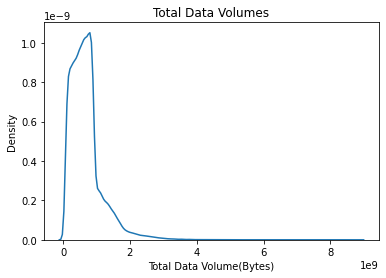

In [57]:
sns.distplot(x = user_info['Total Data(Bytes)'], hist=False)
plt.title('Total Data Volumes')
# Set x-axis label
plt.xlabel('Total Data Volume(Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Social Media (Bytes)')

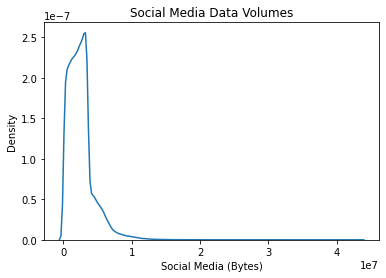

In [58]:
sns.distplot(x = user_info['Social Media'], hist=False)
plt.title('Social Media Data Volumes')
# Set x-axis label
plt.xlabel('Social Media (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Google (Bytes)')

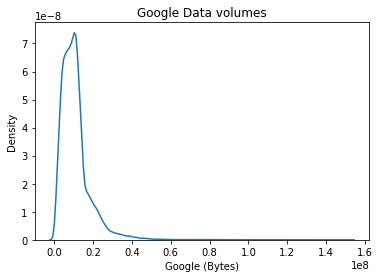

In [56]:
sns.distplot(x = user_info['Google'], hist=False)
plt.title('Google Data volumes')
# Set x-axis label
plt.xlabel('Google (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Email (Bytes)')

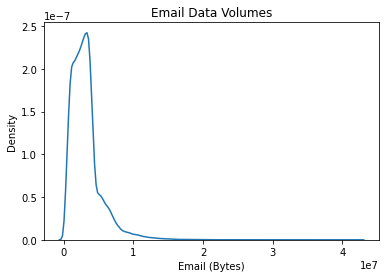

In [55]:
sns.distplot(x = user_info['Email'], hist=False)
plt.title('Email Data Volumes')
# Set x-axis label
plt.xlabel('Email (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Youtube (Bytes)')

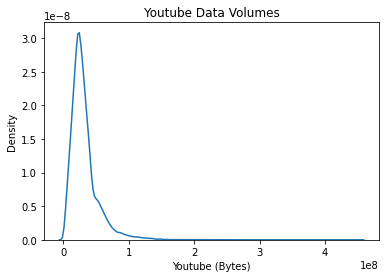

In [54]:
sns.distplot(x = user_info['Youtube'], hist=False)
plt.title('Youtube Data Volumes')
# Set x-axis label
plt.xlabel('Youtube (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Gaming (Bytes)')

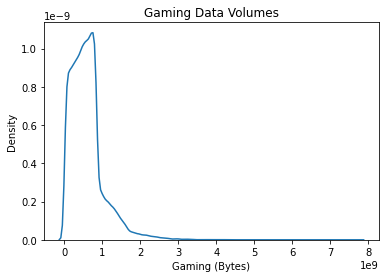

In [52]:
sns.distplot(x = user_info['Gaming'], hist=False)
plt.title('Gaming Data Volumes')
# Set x-axis label
plt.xlabel('Gaming (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Netflixj (Bytes)')

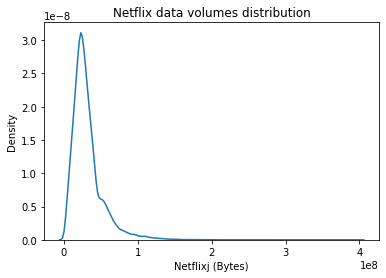

In [53]:
sns.distplot(x = user_info['Netflix'], hist=False)
plt.title('Netflix data volumes distribution')
# Set x-axis label
plt.xlabel('Netflixj (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Other Applications')

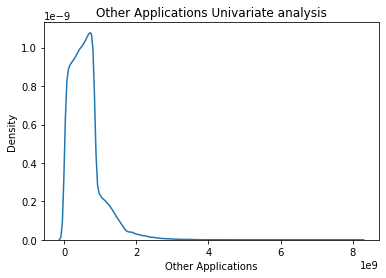

In [50]:
sns.distplot(x = user_info['Other'], hist=False)
plt.title('Other Applications Univariate analysis')
# Set x-axis label
plt.xlabel('Other Applications')



In [ ]:
cols = 3
rows = 3
num_cols =user_info.select_dtypes(exclude='object').columns
fig = plt.figure( figsize=(cols*5, rows*5))
for i, col in enumerate(num_cols):
    
    ax=fig.add_subplot(rows,cols,i+1)
    
    sns.histplot(x = user_info[col], ax = ax)
    
fig.tight_layout()  
plt.show()

#### Bivariete Analysis
We explore the relationship between each application and the total downlink (DL) + uplink (UL) data using a scatter plot

In [15]:
user_info['Total Data(Bytes)']=user_info['Total DL (Bytes)']+user_info['Total UL (Bytes)']
user_info.head()

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other,Total Data(Bytes)
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08,1.391536e+08
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08,2.321240e+08
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08,8.517164e+07
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08,4.265016e+08
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09,1.033092e+09


Text(0, 0.5, 'Total Data(Bytes)')

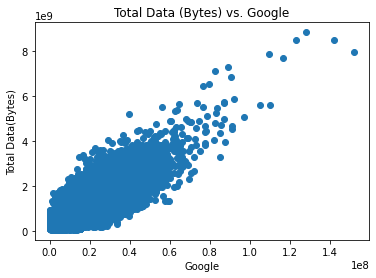

In [29]:
#Total Data(Bytes) against Google
plt.scatter(user_info['Google'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Google')
plt.xlabel('Google')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

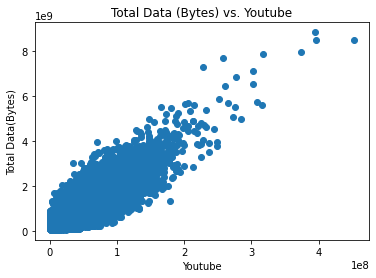

In [36]:
#Total Data(Bytes) against Google
plt.scatter(user_info['Youtube'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Youtube')
plt.xlabel('Youtube')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

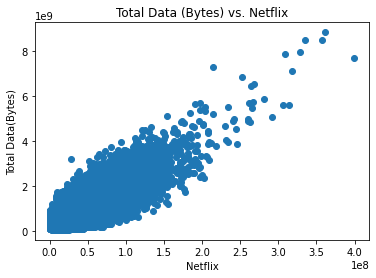

In [37]:
#Total Data(Bytes) against Netflix
plt.scatter(user_info['Netflix'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Netflix')
plt.xlabel('Netflix')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

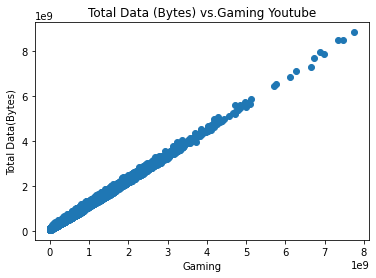

In [38]:
#Total Data(Bytes) against Gaming
plt.scatter(user_info['Gaming'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs.Gaming')
plt.xlabel('Gaming')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

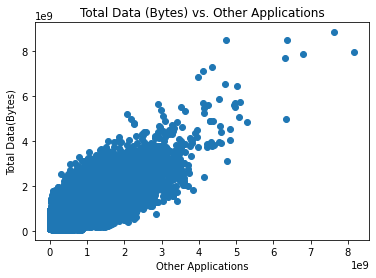

In [39]:
#Total Data(Bytes) against Google
plt.scatter(user_info['Other'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Other Applications')
plt.xlabel('Other Applications')
plt.ylabel('Total Data(Bytes)')

#### Variables Transformation
We segment the users into top five decile classes based on the total duration for all session and compute the total data downlink (DL) + uplink (UP) per decile class

In [20]:
#Segment users into 5 decile classes based on total duration for all sessions
user_info['segment'] = pd.qcut(user_info['Dur. (ms)'], q=5, labels=['class 1', 'class 2', 'class 3', 'class 4', 'class 5'])
user_info.head()

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other,Total Data(Bytes),segment
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08,1.391536e+08,class 5
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08,2.321240e+08,class 5
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08,8.517164e+07,class 2
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08,4.265016e+08,class 2
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09,1.033092e+09,class 5


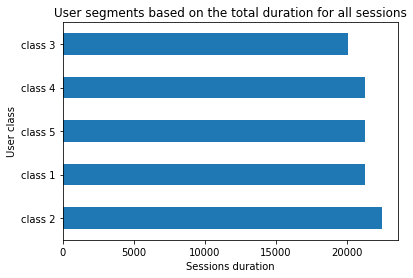

In [22]:
# Visualize the segments in a bar chart
user_info['segment'].value_counts().plot(kind='barh')
plt.title('User segments based on the total duration for all sessions')
plt.xlabel('Sessions duration')
plt.ylabel('User class')
plt.show()

In [26]:
# compute the total data volume (in Bytes) per decile class
user_segment = user_info.groupby(pd.qcut(user_info['Dur. (ms)'], q=5, labels=['class 1', 'class 2', 'class 3', 'class 4', 'class 5']))['Total Data(Bytes)'].sum()
user_segment

Dur. (ms)
class 1    1.152440e+13
class 2    1.233818e+13
class 3    1.167412e+13
class 4    1.391849e+13
class 5    2.409768e+13
Name: Total Data(Bytes), dtype: float64

#### Correlation Analysis
We compute the correlation matrix for the following variables:
<ul>
    <li>Social Media data</li>
    <li>Google data </li>
    <li>Email data</li>
    <li>Youtube data</li>
    <li>Netflix data</li>
    <li>Gaming data</li>
    <li>Other data</li>
 </ul>

In [35]:
#computing the correlation of the above variables
corr = user_info.corr()
corr=corr.drop(columns = ['IMSI', 'Bearer Id', 'Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Total Data(Bytes)'], axis=0)
corr=corr.drop(['IMSI', 'Bearer Id', 'Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Total Data(Bytes)'])
corr

,Social Media,Google,Email,Youtube,Netflix,Gaming,Other
Social Media,1.000000,0.643289,0.634276,0.659589,0.660080,0.590574,0.591662
Google,0.643289,1.000000,0.688695,0.718857,0.716468,0.642482,0.642987
Email,0.634276,0.688695,1.000000,0.704919,0.705730,0.627854,0.631347
Youtube,0.659589,0.718857,0.704919,1.000000,0.738643,0.657713,0.660620
Netflix,0.660080,0.716468,0.705730,0.738643,1.000000,0.657634,0.656074
Gaming,0.590574,0.642482,0.627854,0.657713,0.657634,1.000000,0.586691
Other,0.591662,0.642987,0.631347,0.660620,0.656074,0.586691,1.000000


In [36]:
len(corr.columns)

7

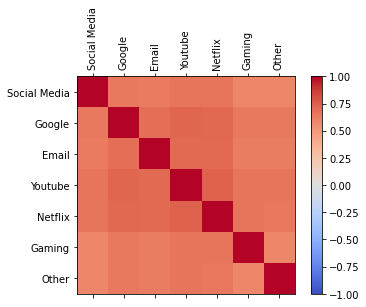

In [37]:
#Visualizing the correlation using a correlation matrix plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
plt.show()

#### Dimensionality Reduction
We perform a principal component analysis (PCA) on the dataset to reduce the dimensions of our data

In [40]:
from sklearn.decomposition import PCA

In [ ]:
# PCA

# Prepare X and Y
Y = user_info.loc[:, '0']
X = user_info.drop(['0'], axis=1)
pca = PCA()
user_info_pca= pca.fit_transform(X=X)

# Store as dataframe and print
df_pca = pd.DataFrame(df_pca)
print(df_pca.shape)  #> (3147, 784)
df_pca.round(2).head()

### 2. User Engagement Analysis

In [41]:
telco_clean.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [43]:
df = telco_clean.groupby('MSISDN/Number').aggregate({'Dur. (ms)': 'sum', 
                                                     'Total UL (Bytes)': 'sum',
                                                     'Total DL (Bytes)': 'sum',
                                 }).reset_index()
df.head()

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes)
0,3.360100e+10,116720.0,36053108.0,8.426375e+08
1,3.360100e+10,181230.0,36104459.0,1.207552e+08
2,3.360100e+10,134969.0,39306820.0,5.566597e+08
3,3.360101e+10,49878.0,20327526.0,4.019932e+08
4,3.360101e+10,37104.0,94280527.0,1.363130e+09


In [44]:
df['Total Traffic (Bytes)']=df['Total UL (Bytes)'] + df['Total DL (Bytes)']
df.head()

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
0,3.360100e+10,116720.0,36053108.0,8.426375e+08,8.786906e+08
1,3.360100e+10,181230.0,36104459.0,1.207552e+08,1.568596e+08
2,3.360100e+10,134969.0,39306820.0,5.566597e+08,5.959665e+08
3,3.360101e+10,49878.0,20327526.0,4.019932e+08,4.223207e+08
4,3.360101e+10,37104.0,94280527.0,1.363130e+09,1.457411e+09


In [47]:
# Top 10 customers per  total duration
dur_df = df.sort_values(by='Dur. (ms)', ascending=False)
dur_df.head(10
           )

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
13107,3.362578e+10,18553754.0,729577380.0,7.770043e+09,8.499621e+09
6394,3.361489e+10,9966898.0,689483001.0,8.156743e+09,8.846226e+09
92486,3.376054e+10,9279434.0,703478581.0,7.811295e+09,8.514774e+09
13451,3.362632e+10,8791927.0,669650721.0,7.301517e+09,7.971167e+09
64825,3.366716e+10,8744914.0,566326364.0,5.052068e+09,5.618394e+09


In [50]:
# Top 10 customers per  total traffic 
traffic_df = df.sort_values(by='Dur. (ms)', ascending=False)
traffic_df.head(10)

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
13107,3.362578e+10,18553754.0,729577380.0,7.770043e+09,8.499621e+09
6394,3.361489e+10,9966898.0,689483001.0,8.156743e+09,8.846226e+09
92486,3.376054e+10,9279434.0,703478581.0,7.811295e+09,8.514774e+09
13451,3.362632e+10,8791927.0,669650721.0,7.301517e+09,7.971167e+09
64825,3.366716e+10,8744914.0,566326364.0,5.052068e+09,5.618394e+09
56896,3.366469e+10,6288730.0,402180804.0,5.279827e+09,5.682007e+09
656,3.360313e+10,6287761.0,435587631.0,4.540607e+09,4.976195e+09
50046,3.366284e+10,5659733.0,365404250.0,3.490821e+09,3.856225e+09
65725,3.366746e+10,5649882.0,266222647.0,2.334299e+09,2.600522e+09
92141,3.376041e+10,5321667.0,521518890.0,6.610852e+09,7.132371e+09


In [52]:
# Normalize Dur. (ms) column
normalized_df=(df-df.mean())/df.std()
normalized_df.head()


,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
0,-0.003994,-0.160763,-0.596979,0.448148,0.380618
1,-0.003994,0.185848,-0.595540,-1.104236,-1.087865
2,-0.003994,-0.062711,-0.505802,-0.166837,-0.194552
3,-0.003994,-0.519903,-1.037646,-0.499443,-0.547815
4,-0.003994,-0.588537,1.034688,1.567451,1.557959


In [60]:
# apply normalization using sklearn
def data_normalizer(df, columns):
    """
    Normalize the columns in the dataframe and return a normalized dataframe
    """
    for col in columns:
        df[col] = MinMaxScaler().fit_transform(np.array(df[col]).reshape(-1,1))
    return df
    

In [61]:
normalized_df=data_normalizer(df, ['Dur. (ms)', 'Total Traffic (Bytes)'])
normalized_df.head()

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
0,3.360100e+10,0.005908,36053108.0,8.426375e+08,0.095931
1,3.360100e+10,0.009387,36104459.0,1.207552e+08,0.014026
2,3.360100e+10,0.006892,39306820.0,5.566597e+08,0.063851
3,3.360101e+10,0.002304,20327526.0,4.019932e+08,0.044148
4,3.360101e+10,0.001615,94280527.0,1.363130e+09,0.161598


In [ ]:
normalized_df.drop(columns=['Total UL (Bytes)', 'Total DL (Bytes)'], inplace=True)


In [66]:
normalized_df.head()

,MSISDN/Number,Dur. (ms),Total Traffic (Bytes)
0,3.360100e+10,0.005908,0.095931
1,3.360100e+10,0.009387,0.014026
2,3.360100e+10,0.006892,0.063851
3,3.360101e+10,0.002304,0.044148
4,3.360101e+10,0.001615,0.161598


In [71]:
#Run k-3 cluster of the 2 metrics
df_new = df[['Dur. (ms)', 'Total Traffic (Bytes)']].copy()
kmeans = KMeans(n_clusters=3).fit(df_new)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.00548698 0.03455451]
 [0.00716544 0.09111816]
 [0.02031001 0.20755519]]


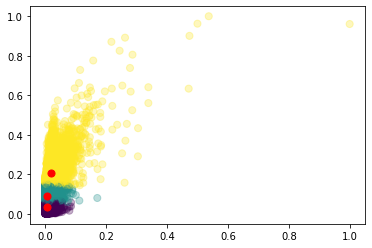

In [74]:
plt.scatter(df_new['Dur. (ms)'], df_new['Total Traffic (Bytes)'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()